/var/folders/_f/zkv575rx6r390c219rqthfrr0000gn/T/ipykernel_76070/3534071725.py:66: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



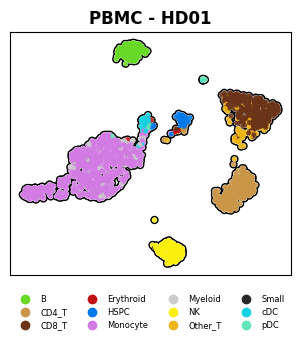

In [ ]:
# pip install plotly
import re
import plotly.graph_objects as go
from espressopro.constants import SIMPLIFIED_PARENT_MAP, DETAILED_PARENT_MAP

# --- helpers ---------------------------------------------------------------
def _extract_class(name: str) -> str:
    # "AveragedSimplified.HSPC.predscore" -> "HSPC"
    m = re.match(r"^[^.]+\.(?P<cls>[^.]+)\.predscore$", str(name))
    return m.group("cls") if m else str(name)

def hex_to_rgba(hex_color: str, alpha: float = 0.30) -> str:
    h = hex_color.lstrip("#")
    r, g, b = int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16)
    return f"rgba({r},{g},{b},{alpha})"

# --- node sets per layer ---------------------------------------------------
broad_nodes = list(SIMPLIFIED_PARENT_MAP.keys())

simplified_nodes = sorted({
    _extract_class(c) for cols in SIMPLIFIED_PARENT_MAP.values() for c in cols
})

detailed_nodes = sorted({
    _extract_class(c) for cols in DETAILED_PARENT_MAP.values() for c in cols
})

# Build layer-qualified node IDs so duplicates (e.g., "ILC") exist in both layers
node_ids = (
    [("Broad", b) for b in broad_nodes] +
    [("Simplified", s) for s in simplified_nodes] +
    [("Detailed", d) for d in detailed_nodes]
)

# Display labels (text shown on nodes)
labels_text = [name for (layer, name) in node_ids]

# index lookup keyed by layer+name
idx = {node_id: i for i, node_id in enumerate(node_ids)}

# --- links: Broad → Simplified --------------------------------------------
links_bs = []
for b, cols in SIMPLIFIED_PARENT_MAP.items():
    for c in cols:
        s = _extract_class(c)
        sid = ("Broad", b)
        tid = ("Simplified", s)
        if sid in idx and tid in idx:
            links_bs.append((idx[sid], idx[tid], 1))

# --- links: Simplified → Detailed ------------------------------------------
links_sd = []
for s, cols in DETAILED_PARENT_MAP.items():
    for c in cols:
        d = _extract_class(c)
        sid = ("Simplified", s)
        tid = ("Detailed", d)
        if sid in idx and tid in idx:
            links_sd.append((idx[sid], idx[tid], 1))

# --- color map --------------------------------------------------------------
# Broad layer
color_map = {
    "Immature": "#0079ea",
    "Mature":   "#CFCFCF"
}

# Simplified layer
color_map.update({
    "HSPC":      "#0079ea",
    "Erythroid": "#c11212",
    "pDC":       "#62E6B8",
    "Monocyte":  "#D27CE3",
    "Myeloid":   "#8D43CD",
    "CD4_T":     "#C99546",
    "CD8_T":     "#6B3317",
    "B":         "#68D827",
    "cDC":       "#16D2E3",
    "Other_T":   "#EDB416",
    "ILC":       "#B9BCA3",
    "Macrophage":"#B08968",
    "Stroma":    "#4E4848",
    "NK":        "#FBEF0D",
})
# Propagate each simplified parent's color to its detailed children unless overridden
for s, cols in DETAILED_PARENT_MAP.items():
    parent_col = color_map.get(s, "#999999")
    for c in cols:
        d = _extract_class(c)
        color_map.setdefault(d, parent_col)

default_node_color = "#CCCCCC"

# Node colors by display name (same color for same name across layers)
node_colors = [color_map.get(name, default_node_color) for (_, name) in node_ids]

# Link colors = translucent source color
link_colors = []
for s, t, _ in links_bs + links_sd:
    src_name = labels_text[s]
    base = color_map.get(src_name, "#999999")
    link_colors.append(hex_to_rgba(base, 0.30))

# --- draw sankey ------------------------------------------------------------
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=12,
        thickness=18,
        line=dict(width=0.6, color="black"),
        label=labels_text,
        color=node_colors,
    ),
    link=dict(
        source=[s for s, t, v in links_bs + links_sd],
        target=[t for s, t, v in links_bs + links_sd],
        value=[v for s, t, v in links_bs + links_sd],
        color=link_colors,
    )
)])

fig.update_layout(
    title_text="Ontology relationships: Broad → Simplified → Detailed",
    font=dict(size=12),
    margin=dict(l=10, r=10, t=40, b=10),
    width=1100,
    height=1000,
)
fig.show()
